# Partie A: ANALYSE ET PRÉTRAITEMENT
## 1. Exploration et reporting

In [2]:
import yfinance as yf
import pandas as pd

# Auto adjust est activé (True) car cela permet 
# de mieux construire le modèle de prédiction et d'atténuer les baisses artificielles lorsque BNP verse des dividendes.
ticker = 'BNP.PA'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01',auto_adjust=True)
df = pd.DataFrame(data)
df.columns = [col[0] for col in df.columns]

# Afficher les premières lignes des données
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BNP.PA,BNP.PA,BNP.PA,BNP.PA,BNP.PA
Date,,,,,
2020-01-02,37.128830,37.419872,36.851645,36.865504,2783637
2020-01-03,36.685329,36.844710,36.442794,36.775415,2535225
2020-01-06,36.505161,36.519021,35.784482,36.061667,2494787
2020-01-07,36.491302,36.823923,36.352710,36.678402,2022813
2020-01-08,36.574459,36.740771,36.040879,36.221050,2893097


In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,37.128830,37.419872,36.851645,36.865504,2783637
2020-01-03,36.685329,36.844710,36.442794,36.775415,2535225
2020-01-06,36.505161,36.519021,35.784482,36.061667,2494787
2020-01-07,36.491302,36.823923,36.352710,36.678402,2022813
2020-01-08,36.574459,36.740771,36.040879,36.221050,2893097


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1283 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1283 non-null   float64
 1   High    1283 non-null   float64
 2   Low     1283 non-null   float64
 3   Open    1283 non-null   float64
 4   Volume  1283 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 60.1 KB


In [5]:
df.describe()

,Close,High,Low,Open,Volume
count,1283.000000,1283.000000,1283.000000,1283.000000,1.283000e+03
mean,45.540238,46.084615,44.991612,45.544020,3.635156e+06
std,11.889549,11.883122,11.872672,11.867491,2.140004e+06
min,17.095335,17.559619,16.980995,17.254716,4.077800e+05
25%,38.552671,39.319040,38.084092,38.741565,2.320286e+06
50%,45.719307,46.299958,45.281382,45.806888,3.111764e+06
75%,54.766481,55.337990,54.339838,54.785219,4.157010e+06
max,68.339996,68.660004,67.910004,68.500000,1.903434e+07


## 2. Prétraitement des données

In [6]:
# Il n'y a pas de valeurs manquantes
df.isnull().sum() 

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [7]:
import pandas_profiling

profile = pandas_profiling.ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

C:\Users\Carl\AppData\Local\Temp\ipykernel_15292\1060527481.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

```markdown
On remarque que les colonnes `Close`, `High`, `Low` et `Open` sont très fortement corrélées (0.99), donc elles représentent essentiellement la même information. Pour le contexte de prédiction, nous allons utiliser uniquement la colonne `Close`.

Concernant le volume, une prédiction du volume à l'instant T+1 sera écartée. Bien qu'il soit corrélé à -0.5 avec le `Close`, une prédiction du nombre de personnes ayant tradé sur l'action est inutile dans ce contexte. Des techniques de décalage du volume, où le volume à l'instant T est placé sur T-1 et ainsi de suite, peuvent améliorer légèrement les résultats, mais pour le moment, nous n'utiliserons pas le volume.
```

In [8]:
import plotly.express as px

fig = px.histogram(df, x='Close', nbins=50, title='Histogram of Close Prices', 
                   labels={'Close': 'Close Price'}, 
                   color_discrete_sequence=['skyblue'])
fig.show()

## 3.  Segmentation du marché boursier

[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  57 of 57 completed


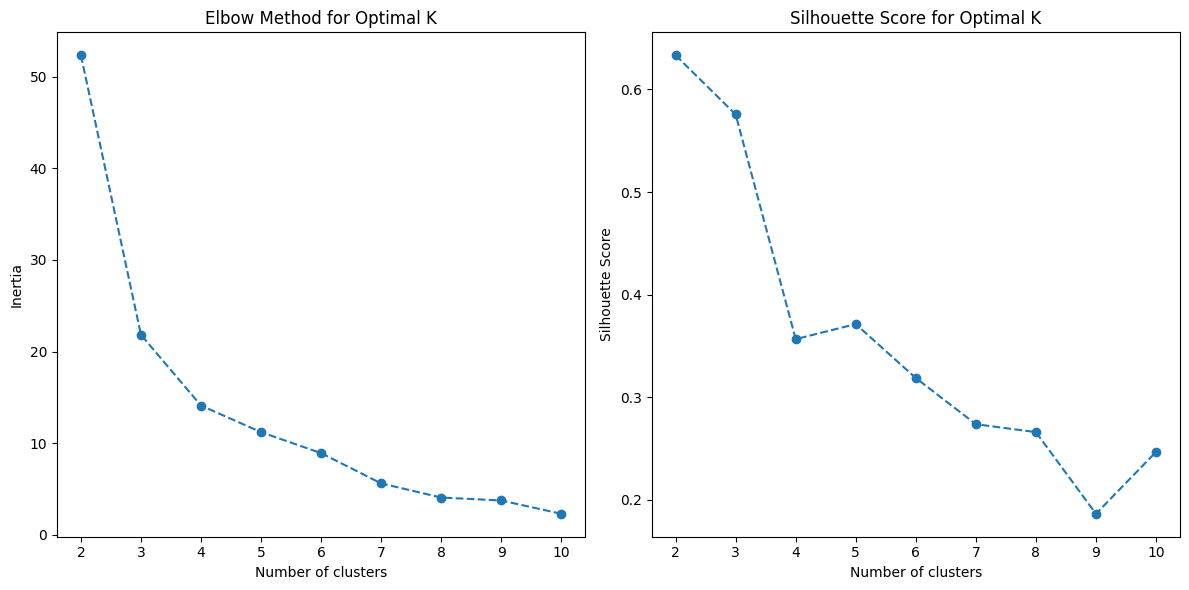

In [9]:
%matplotlib inline 

import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

tickers = [
    'BNP.PA', 'GLE.PA', 'ACA.PA', 'SAN.PA', 'SGO.PA', 'ML.PA', 'CAP.PA', 'ORA.PA', 
    'VIE.PA', 'AI.PA', 'DG.PA', 'RNO.PA', 'ENGI.PA', 'MC.PA', 'KER.PA', 'OR.PA', 
    'HO.PA', 'RI.PA', 'FR.PA',  
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'JPM', 'BAC', 'C', 'WFC', 
    'NFLX', 'NVDA', 'XOM', 'CVX', 'PG', 'KO', 'PEP', 'MCD', 'DIS', 'V',  
    'HSBA.L', 'BP.L', 'RIO.L', 'BATS.L', 'ULVR.L', 'LLOY.L', 'BARC.L', 'VOD.L', 
    'TSCO.L', 'GSK.L', 'AZN.L', 'PRU.L', 'BT-A.L', 'NG.L', 'SBRY.L', 'LGEN.L', 'RR.L', 
    'DGE.L'
]

data = yf.download(tickers, start="2020-01-01", end="2025-01-01")['Close']
data.dropna(axis=1, how='all', inplace=True)

# Creation des features pour le clustering
returns = data.pct_change(fill_method=None).dropna()
rolling_mean = data.rolling(window=10).mean()
annual_return_means = returns.mean() * 252
annual_return_variances = returns.var() * 252

features = pd.DataFrame({
    'Close': data.iloc[-1],  
    'Return': returns.mean(),  
    'MA_10': rolling_mean.iloc[-1],  
    'Annual_Return_Mean': annual_return_means,  
    'Annual_Return_Variance': annual_return_variances  
}).dropna()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

```
En regardant les différents stocks que j'ai pris de France, des USA et du Royaume-Uni, je pense que le nombre de clusters idéal est 3. Cela permet de réduire considérablement l'inertie tout en gardant un score de silhouette élevé, ce qui constitue un bon compromis.

Les graphiques montrent l'évolution de l'inertie et du score de silhouette en fonction du nombre de clusters. L'inertie diminue à mesure que le nombre de clusters augmente, mais le gain marginal diminue après 3 clusters. Le score de silhouette, qui mesure la cohésion des clusters, reste relativement élevé pour 3 clusters, indiquant une bonne séparation entre les groupes.
```

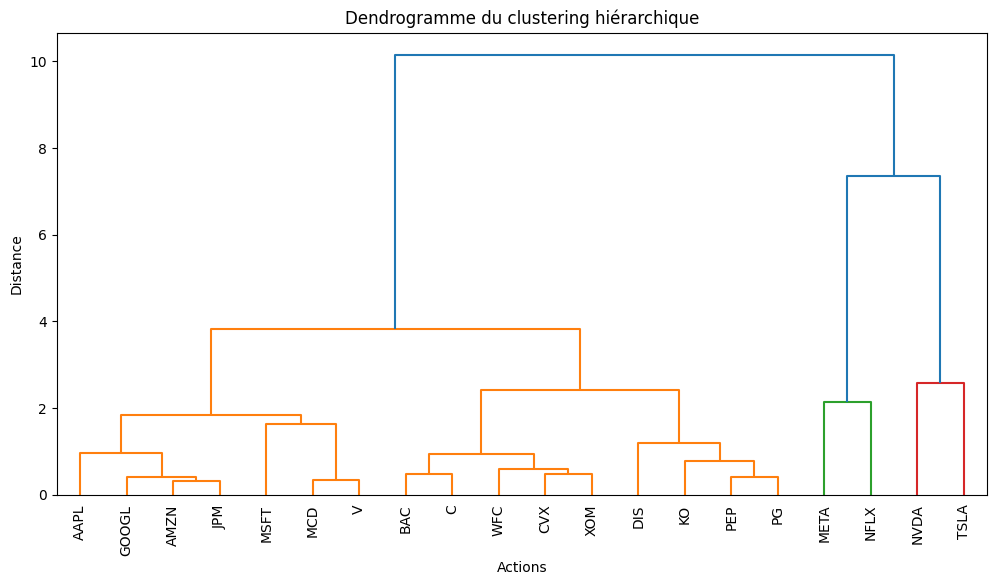

In [10]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(features_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=features.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogramme du clustering hiérarchique")
plt.xlabel("Actions")
plt.ylabel("Distance")
plt.show()

```
En appliquant le **clustering hiérarchique**, nous observons clairement les différences entre les actions et l’émergence de trois groupes distincts. Cette approche permet d’identifier les titres ayant des comportements similaires en termes de rendement et de volatilité. C’est un outil précieux dans l’analyse financière, facilitant la diversification des investissements et l’optimisation des stratégies de portefeuille.

```


## 4. Détection d’anomalies

In [11]:
from sklearn.ensemble import IsolationForest

# On choisit un contamination de 5% pour les anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(returns)

anomalies = returns[anomaly_labels == -1]
print(anomalies.index)

DatetimeIndex(['2020-02-24', '2020-02-27', '2020-02-28', '2020-03-02',
               '2020-03-04', '2020-03-06', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-04-01', '2020-04-02',
               '2020-04-06', '2020-04-09', '2020-04-15', '2020-04-17',
               '2020-04-21', '2020-04-29', '2020-04-30', '2020-05-14',
               '2020-05-18', '2020-05-27', '2020-06-03', '2020-06-05',
               '2020-06-11', '2020-09-21', '2020-10-28', '2020-11-03',
               '2020-11-04', '2020-11-09', '2020-11-24', '2021-01-06',
               '2022-02-24', '2022-02-25', '2022-03-01', '2022-03-04',
               '2022-03-07', '2022-03-09', '2022-03-16', '2022-03-29',
               '2022-05-18', '2022-06-24', '2022-10-04', '2022-10-13',
      

# Liste des anomalies et leurs causes  

- **24-28 février 2020** → Début du krach COVID-19, panique des marchés.  
- **9-23 mars 2020** → Chute historique des indices boursiers à cause des confinements.  
- **6 janvier 2021** → Assaut du Capitole aux États-Unis, tensions politiques.  
- **24-25 février 2022** → Début de la guerre en Ukraine, chute des marchés.  
- **1-9 mars 2022** → Volatilité due aux sanctions économiques et crise énergétique.  
- **10 novembre 2022** → Baisse surprise de l’inflation aux USA, rebond des actions.  
- **15 mars 2023** → Crise bancaire après la faillite de **Silicon Valley Bank (SVB)**.  


# Partie B: PRÉVISION DES ACTIONS DE BNP 
## 1.  Analyse des données de BNP

[*********************100%***********************]  1 of 1 completed

Test de Shapiro-Wilk: Statistique=0.9774, p-valeur=0.0000
Test de Dickey-Fuller: Statistique=-1.2167, p-valeur=0.6664
Valeur critique: {'1%': -3.4354651071284366, '5%': -2.8637988833962726, '10%': -2.567972648569954}


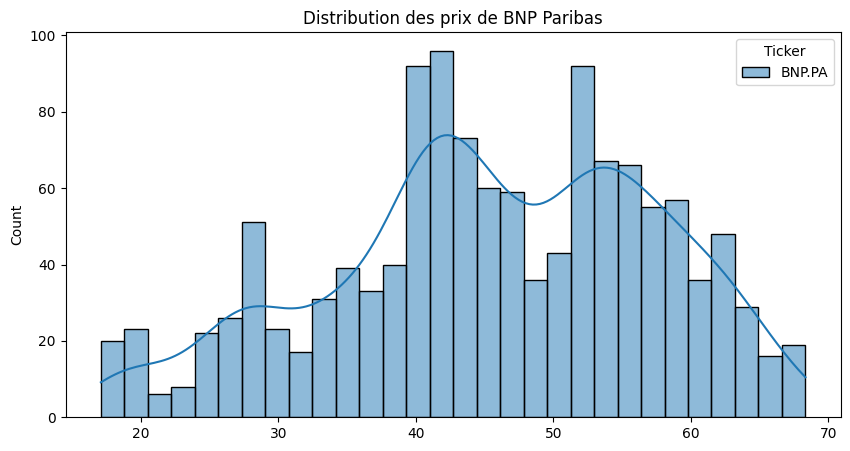

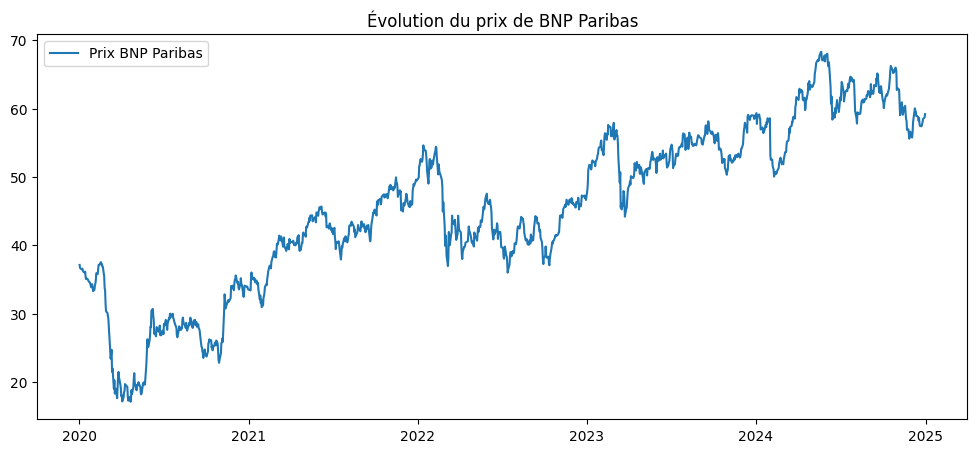

In [12]:
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats  
import seaborn as sns

bnp = yf.download("BNP.PA", start="2020-01-01", end="2025-01-01")['Close']

desc_stats = bnp.describe()
shapiro_test = stats.shapiro(bnp.dropna()) #(normalité)
adf_test = adfuller(bnp.dropna()) #(stationnarité)

print(f"Test de Shapiro-Wilk: Statistique={shapiro_test.statistic:.4f}, p-valeur={shapiro_test.pvalue:.4f}")
print(f"Test de Dickey-Fuller: Statistique={adf_test[0]:.4f}, p-valeur={adf_test[1]:.4f}")
print(f"Valeur critique: {adf_test[4]}")

plt.figure(figsize=(10, 5))
sns.histplot(bnp, kde=True, bins=30)
plt.title("Distribution des prix de BNP Paribas")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(bnp, label="Prix BNP Paribas")
plt.title("Évolution du prix de BNP Paribas")
plt.legend()
plt.show()

### Résultats des tests statistiques pour les actions de BNP Paribas

#### 1. **Test de Shapiro-Wilk (Normalité)**

- **Statistique du test**: 0.9774
- **p-valeur**: 0.0000

Le **test de Shapiro-Wilk** est utilisé pour tester si les données suivent une distribution normale. 

- **Interprétation**: 
  - La p-valeur obtenue est très inférieure au seuil de 0.05, ce qui indique que les données ne suivent pas une distribution normale.
  - Cela signifie que la distribution des prix des actions de BNP Paribas n'est pas normale, ce qui pourrait suggérer que les prix sont influencés par d'autres facteurs ou par des événements spécifiques dans le temps.

#### 2. **Test de Dickey-Fuller (Stationnarité)**

- **Statistique du test**: -1.2167
- **p-valeur**: 0.6664
- **Valeurs critiques**:
  - 1%: -3.4355
  - 5%: -2.8638
  - 10%: -2.5680

Le **test de Dickey-Fuller** est utilisé pour tester la stationnarité d'une série temporelle. 

- **Interprétation**: 
  - La statistique du test (-1.2167) est bien supérieure aux valeurs critiques pour les seuils de 1%, 5%, et 10%, ce qui signifie que nous ne pouvons pas rejeter l'hypothèse nulle.
  - La p-valeur de 0.6664 est également bien au-dessus du seuil de 0.05, ce qui indique que la série temporelle des prix des actions de BNP Paribas **n'est pas stationnaire**.
  - Cela suggère que les prix des actions de BNP Paribas suivent une tendance ou sont influencés par des effets non stationnaires au fil du temps.

---

## 2. Modélisation avancée avec SARIMAX

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

bnp

Ticker,BNP.PA
Date,
2020-01-02,37.128830
2020-01-03,36.685329
2020-01-06,36.505161
2020-01-07,36.491302
2020-01-08,36.574459
...,...
2024-12-23,57.439999
2024-12-24,57.540001
2024-12-27,58.540001


In [14]:
# On prend les 50 dernières valeurs pour le test
df_train = bnp.iloc[:-50].copy() 
df_test = bnp.iloc[-50:].copy()   

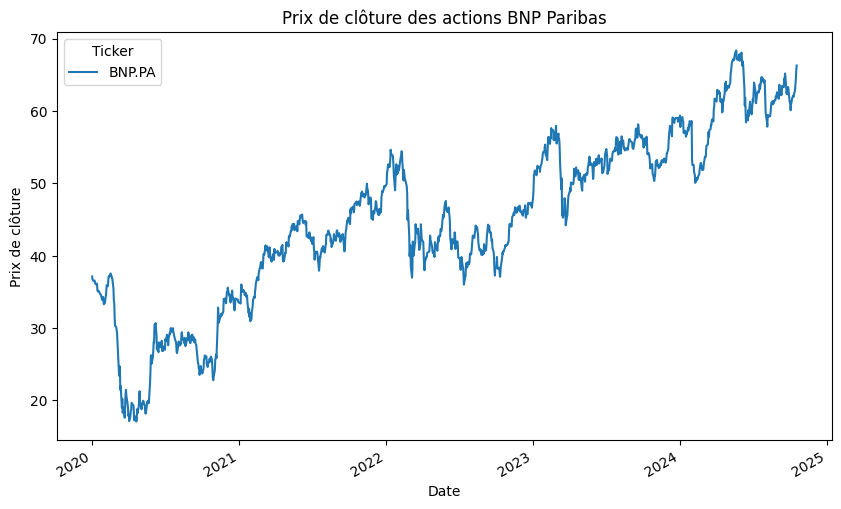

In [15]:
df_train.plot(figsize=(10, 6))
plt.title('Prix de clôture des actions BNP Paribas')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.show()

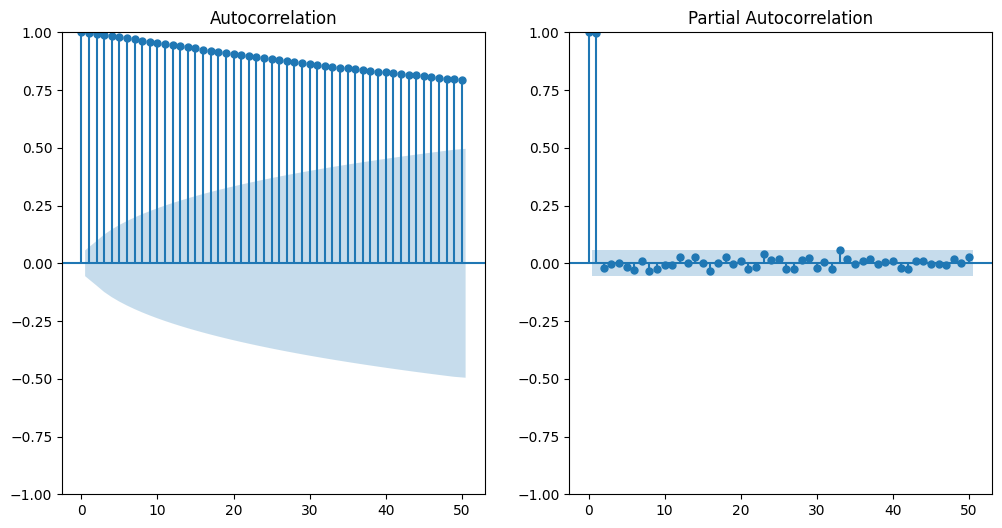

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_train.dropna(), lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_train.dropna(), lags=50, ax=plt.gca())
plt.show()

### Analyse de la série temporelle

L'image montre deux graphiques d'analyse de série temporelle :

#### **Autocorrelation Function (ACF) (à gauche)**

Les barres montrent la corrélation d'une série temporelle avec ses propres valeurs décalées (lags).

- Ici, l'ACF décroît lentement, indiquant une forte dépendance des valeurs passées. Cela suggère une **non-stationnarité** (possiblement une tendance).

#### **Partial Autocorrelation Function (PACF) (à droite)**

Montre la corrélation entre une observation et ses décalages, en éliminant l'effet des autres lags intermédiaires.

- Ici, seule la **première valeur** a une forte corrélation significative, puis les valeurs suivantes sont proches de zéro. Cela suggère qu'un **AR(1)** (modèle autorégressif d'ordre 1) pourrait être adapté.

### **Conclusion**

- La série semble **non stationnaire** (ACF décroît lentement). Un **différenciation** pourrait être nécessaire avant d'ajuster un modèle ARIMA.


Test de Dickey-Fuller après différenciation: Statistique=-33.6959, p-valeur=0.0000


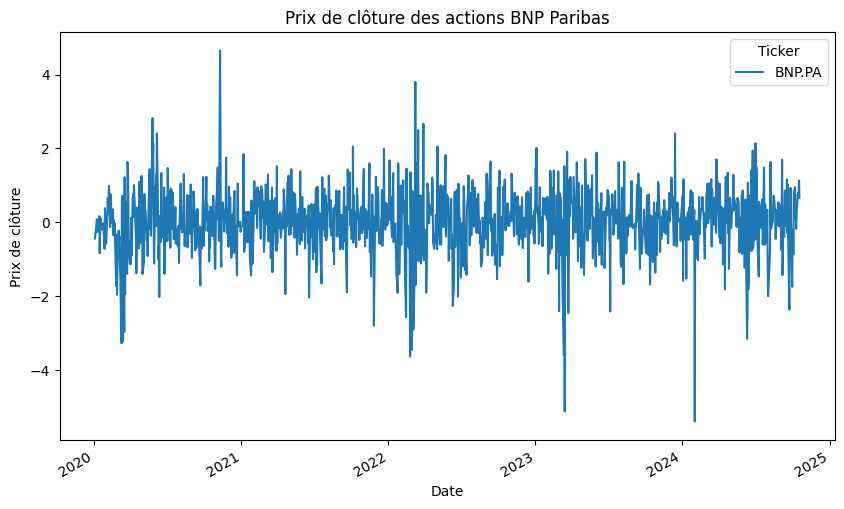

In [17]:
# Différenciation de la série pour la rendre stationnaire
data_train_diff = df_train.diff().dropna()

# Vérification de la stationnarité après différenciation
adf_test_diff = adfuller(data_train_diff)
print(f"Test de Dickey-Fuller après différenciation: Statistique={adf_test_diff[0]:.4f}, p-valeur={adf_test_diff[1]:.4f}")

data_train_diff.plot(figsize=(10, 6))
plt.title('Prix de clôture des actions BNP Paribas')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.show()


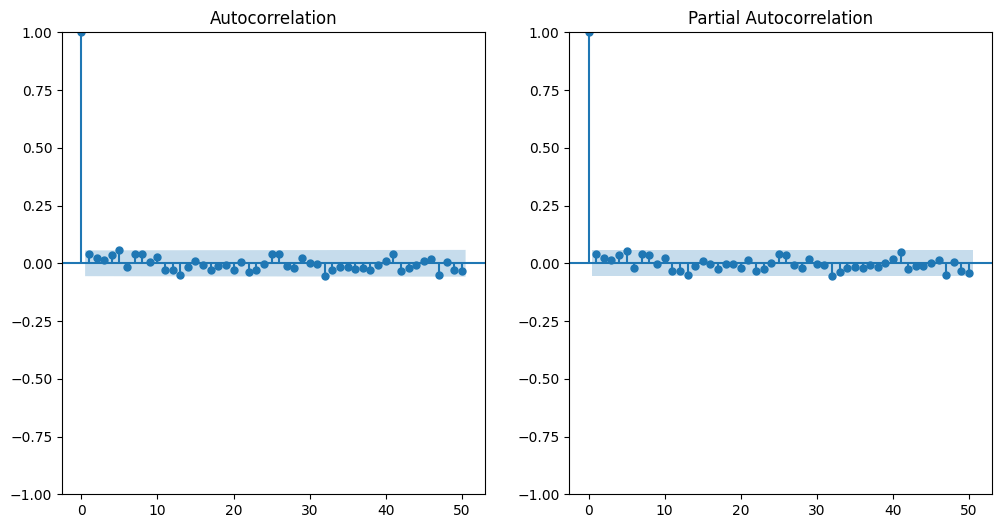

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_train_diff.dropna(), lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(data_train_diff.dropna(), lags=50, ax=plt.gca())
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA
# Ici on met d = 1 car on a différencié la série une fois
# Et en regardant les deux graphes ACF et PACF on peut choisir p = 1 et q = 1

model = ARIMA(df_train, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 BNP.PA   No. Observations:                 1233
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1565.358
Date:                Tue, 25 Mar 2025   AIC                           3136.715
Time:                        19:41:59   BIC                           3152.064
Sample:                             0   HQIC                          3142.490
                               - 1233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8125      0.119      6.814      0.000       0.579       1.046
ma.L1         -0.7734      0.132     -5.869      0.000      -1.032      -0.515
sigma2         0.7432      0.018     41.240      0.0

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



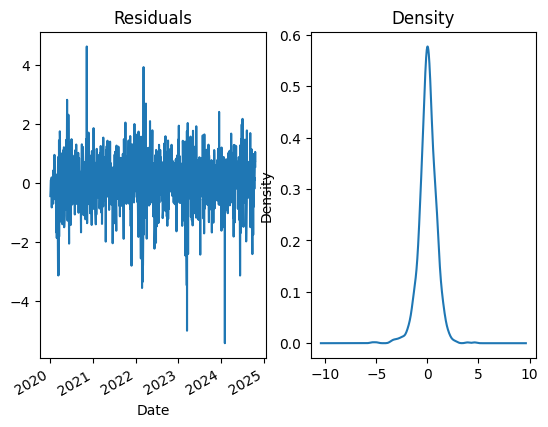

In [20]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

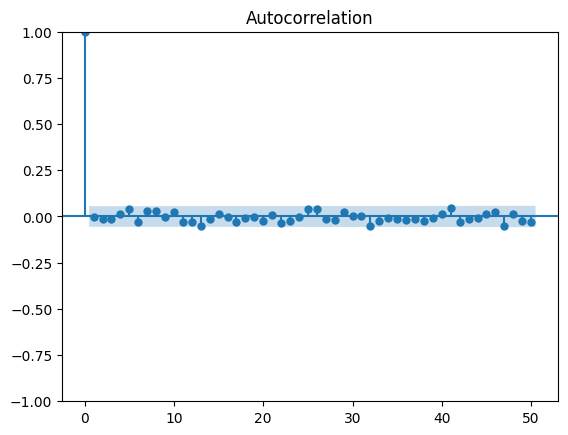

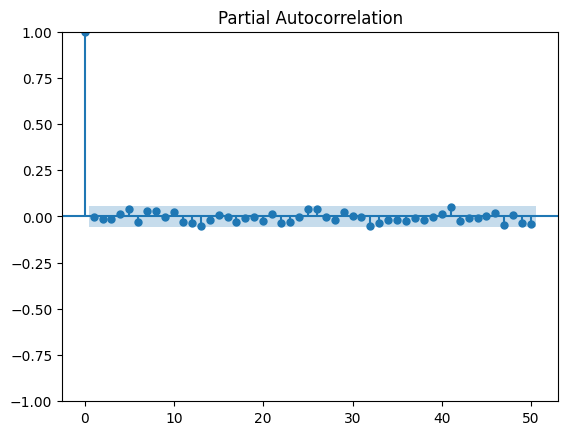

In [21]:
plot_acf(residuals, lags=50)
plot_pacf(residuals, lags=50)
plt.show()

In [22]:
forecast_test = model_fit.forecast(steps=50)
forecast_test

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



1233    66.377127
1234    66.464174
1235    66.534901
1236    66.592369
1237    66.639063
1238    66.677003
1239    66.707830
1240    66.732878
1241    66.753230
1242    66.769767
1243    66.783203
1244    66.794121
1245    66.802991
1246    66.810199
1247    66.816055
1248    66.820814
1249    66.824680
1250    66.827821
1251    66.830374
1252    66.832448
1253    66.834133
1254    66.835503
1255    66.836615
1256    66.837519
1257    66.838254
1258    66.838850
1259    66.839335
1260    66.839729
1261    66.840049
1262    66.840310
1263    66.840521
1264    66.840693
1265    66.840832
1266    66.840946
1267    66.841038
1268    66.841113
1269    66.841173
1270    66.841223
1271    66.841263
1272    66.841296
1273    66.841322
1274    66.841344
1275    66.841361
1276    66.841375
1277    66.841387
1278    66.841396
1279    66.841404
1280    66.841410
1281    66.841415
1282    66.841419
Name: predicted_mean, dtype: float64

## SARIMAX

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

# Liste des actions françaises et américaines à tester
stocks = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "SAN.PA", "AI.PA", "MC.PA", "OR.PA",
    "NFLX", "NVDA", "BRK-B", "JPM", "V", "MA", "DIS", "PYPL", "ADBE", "INTC",
    "PFE", "KO", "PEP", "T", "XOM", "CSCO", "COST", "BA", "NKE", "IBM",
    "GS", "GM", "F", "MCD", "SBUX", "GE", "BABA", "AMD", "UBER", "LYFT",
    "AIR.PA", "DG.PA", "BN.PA", "VIE.PA", "EL.PA", "HO.PA", "CA.PA", "ACA.PA"
]
target_stock = "BNP.PA"
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(stocks + [target_stock], start=start_date, end=end_date)["Close"]

def granger_test(df, target, max_lag=5, significance=0.05):
    influencing_stocks = []
    for stock in df.columns:
        if stock == target:
            continue
        
        test_result = grangercausalitytests(df[[target, stock]].dropna(), max_lag)
        
        for lag in range(1, max_lag + 1):
            p_value = test_result[lag][0]['ssr_ftest'][1]
            if p_value < significance:
                influencing_stocks.append(stock)
                print(f"{stock} cause Granger de {target} avec p={p_value:.4f} (lag={lag})")
                break
    return influencing_stocks

influencing_stocks = granger_test(data, target_stock)

data_influencing = data[influencing_stocks + [target_stock]]

[*********************100%***********************]  48 of 48 completed



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6885  , p=0.0306  , df_denom=1244, df_num=1
ssr based chi2 test:   chi2=4.6998  , p=0.0302  , df=1
likelihood ratio test: chi2=4.6910  , p=0.0303  , df=1
parameter F test:         F=4.6885  , p=0.0306  , df_denom=1244, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8384  , p=0.0589  , df_denom=1241, df_num=2
ssr based chi2 test:   chi2=5.6997  , p=0.0579  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8384  , p=0.0589  , df_denom=1241, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5353  , p=0.0143  , df_denom=1238, df_num=3
ssr based chi2 test:   chi2=10.6658 , p=0.0137  , df=3
likelihood ratio test: chi2=10.6203 , p=0.0140  , df=3
parameter F test:         F=3.5353  , p=0.0143  , df_denom=1238, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0451  , p=0.

<Axes: xlabel='Date'>

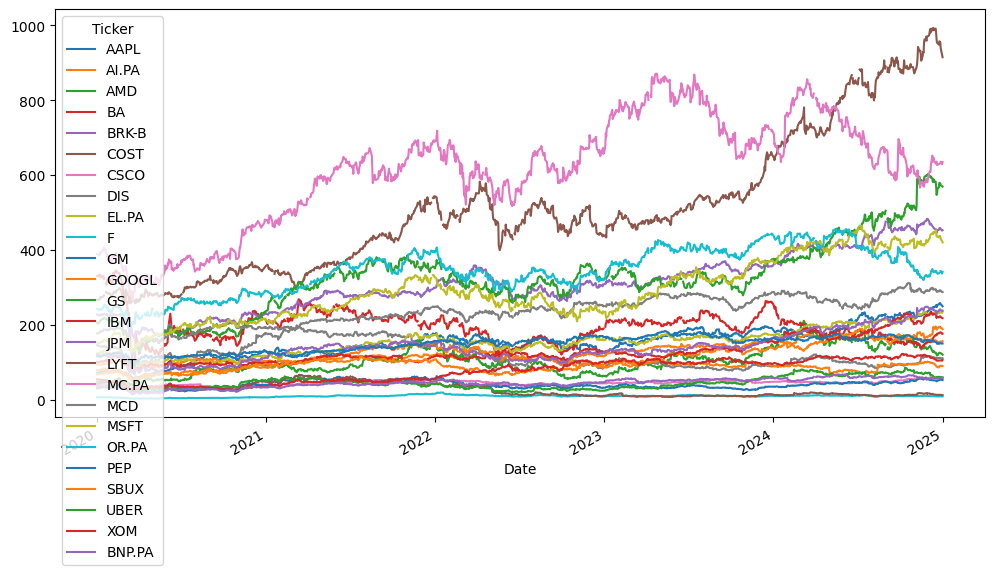

In [24]:
data_influencing.plot(figsize=(12, 6))

In [25]:
df_influence_train = data_influencing.iloc[:-50].copy() 
df_influence_test = data_influencing.iloc[-50:].copy()   

df_influence_train = df_influence_train.dropna()
df_influence_test = df_influence_test.dropna()

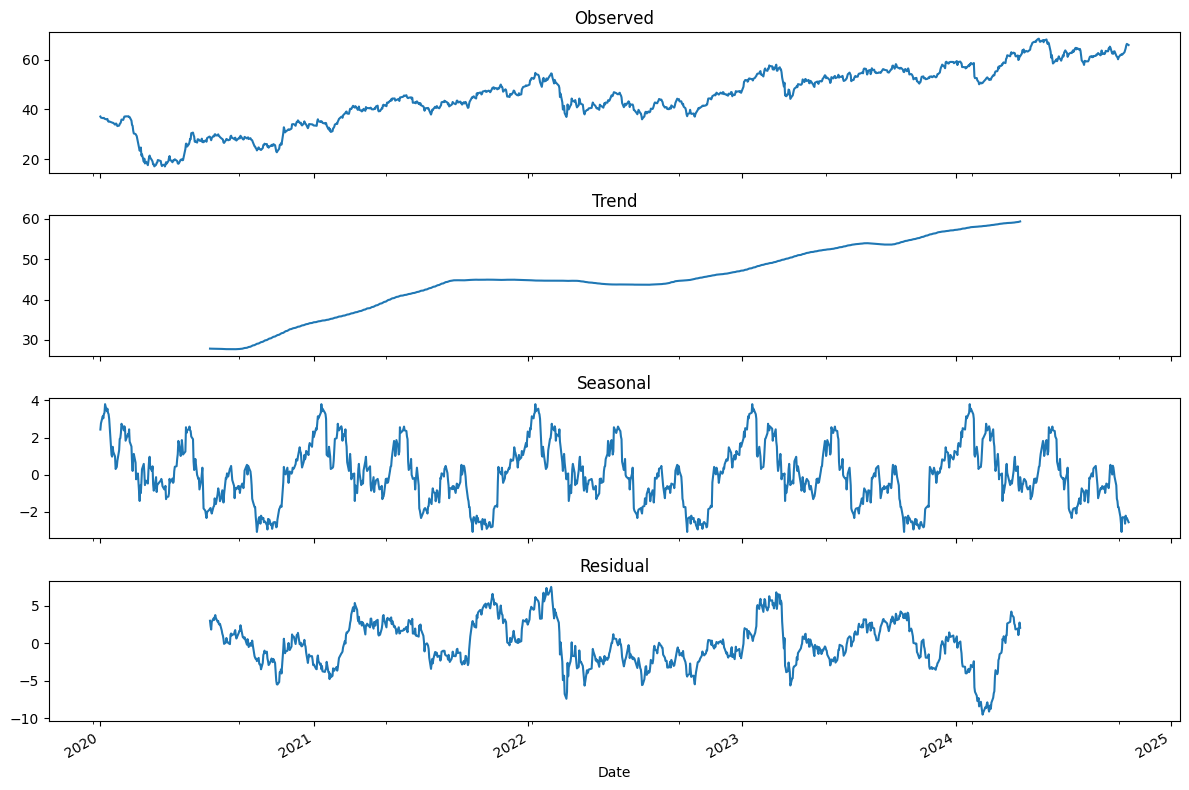

In [26]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(df_influence_train['BNP.PA'], model='additive', period=252)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

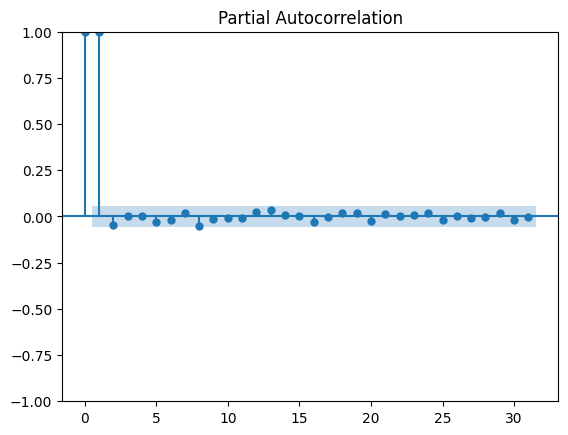

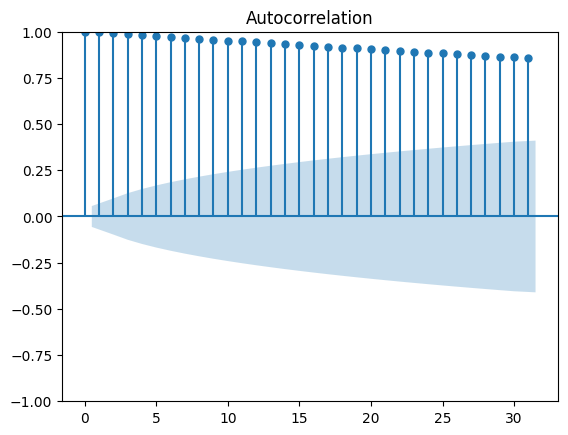

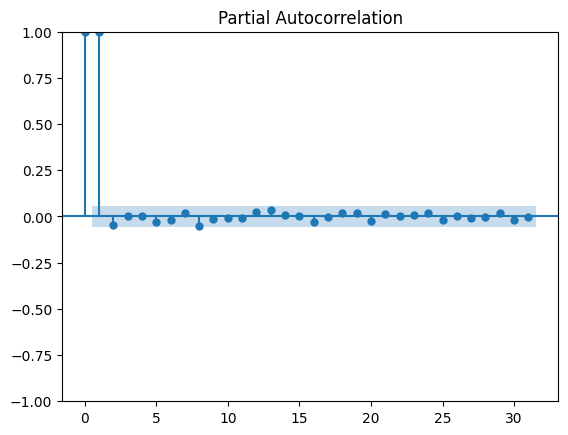

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_influence_train['BNP.PA'])
plot_pacf(df_influence_train['BNP.PA'])

In [29]:
df_influence_train.shape   

(1200, 25)

In [32]:
df_influence_train['BNP.PA'].shape

(1200,)

In [30]:
exogenous_vars = df_influence_train.drop(columns=["BNP.PA"])
# exogenous_vars = df_influence_train.drop(columns=["BNP.PA"])

model = SARIMAX(df_influence_train['BNP.PA'],
                exog=exogenous_vars,
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 252),  
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

print(results.summary())

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Carl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



KeyboardInterrupt: 